In [1]:
#❗❗❗❗❗
# This Code require extremely high RAM, around 100GB+
# To direcyly run this code, plase beware the memory requirement first
# ❗❗❗❗❗

from freecond_src.freecond_utils import get_pipeline_forward
from freecond_src.freecond import fc_config
from diffusers import DDIMScheduler
from PIL import Image
import torch
torch.cuda.set_device(0)
pipeline, forward = get_pipeline_forward(method="sd",variant="sd15", device="cuda")

# pipeline, forward = get_pipeline_forward(method="cn")

# pipeline, forward = get_pipeline_forward(method="hdp",variant="sd15",device="cuda")

# pipeline, forward = get_pipeline_forward(method="pp",device="cuda")

# pipeline, forward = get_pipeline_forward(method="bn",device="cuda")

# pipeline, forward = get_pipeline_forward(method="sd",variant="sdxl",device="cuda")

# pipeline.scheduler=DDIMScheduler.from_config(pipeline.scheduler.config) # This was used during the experiment

❗❗❗ Be sure using correct python environment, the python environment are different for methods 
🔄 Building Stable-Diffusion-Inpainting FreeCond control...
# Load backbone model
## Load backbone model = Stable Diffusion Inpainting 1.5


vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /nfs/home/bluedyee/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /nfs/home/bluedyee/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/nfs/home/bluedyee/miniconda3/envs/hdpainter/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
An error occurred while trying to fetch /nfs/home/bluedyee/.cache/huggingface/hub

In [5]:
from PIL import ImageFont
from PIL import ImageDraw 
import torch
import torch.nn.functional as F

def vis_cross_atn_dict(cross_atn_dict, token_pos=1, step=0, layer=31, indicator="c"):
    soft_sim=cross_atn_dict[indicator][step][layer]
    # sum heads
    soft_sim=torch.sum(soft_sim, 0, keepdim=False) 
    atn_map=soft_sim[:,token_pos]
    n=int(atn_map.shape[0]**0.5)
    atn_map=atn_map.reshape((n,n))*255
    return Image.fromarray(atn_map.numpy().astype("uint8"))

def vis_self_1c(self_atn_tensor, mask):
    # (4096, 4096)
    N, M = self_atn_tensor.shape
    H = int(N**0.5)
    W = int(M**0.5)
    resized_mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).cpu().to(torch.float), size=(H, W), mode='bilinear', align_corners=False)
    out_tensor = self_atn_tensor.clone()
    flat_mask = torch.flatten(resized_mask).to(bool)
    out_tensor[:,flat_mask]*=1
    out_tensor[:,~flat_mask]*= 0
    out_tensor=torch.sum(out_tensor, dim=1)
    return torch.reshape(out_tensor, (H,W))


# Vis with prompt control

In [ ]:
from PIL import Image
from diffusers import DDIMScheduler
from diffusers.utils import load_image, make_image_grid
from freecond_src.vis_attn_control import VISAttentionControl, regiter_attention_editor_diffusers

###
nprompt="word, bad quality, bad anatomy, ugly, mutation, blurry, error"
SEED=777
mask=Image.open("./demo_data/mask_1_2.png").convert("L").resize((512,512))
init_image=Image.open("./demo_data/img_1_2.jpg").convert("RGB").resize((512,512))
prompt="A golden retriever wearing astronaut gear, in cyberpunk style"
nprompt="word, bad quality, bad anatomy, ugly, mutation, blurry, error"

# store self-attention hidden layer to CPU
freecond_editor = VISAttentionControl(start_step=0,end_step=50, start_layer=0, end_layer=16, vis_self=True, vis_cross=True)
regiter_attention_editor_diffusers(pipeline, freecond_editor)

# Default to SDI
fc_control=fc_config(change_step=0,fg_1=1,fg_2=1,bg_1=0,bg_2=0,hq_1=1,hq_2=1,lq_1=1,lq_2=1,fq_th=32)
# Setting FreeCond control for SDI15
torch.manual_seed(777)
default_out = forward(fc_control,init_image=init_image,mask_image=mask,prompt=prompt,negative_prompt=nprompt)

Activating VIS Attention Control...
# Visualize cross attention (1, 3, 5, 7... layers) = True
# Visualize self attention (0, 2, 4, 6 ... layers)= True


/nfs/home/bluedyee/miniconda3/envs/hdpainter/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/50 [00:00<?, ?it/s]

/nfs/home/bluedyee/github_repo/INPAINTING/FreeCond/freecond_src/freecond.py:75: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:31.)
  x_freq = fft.fftn(x, dim=(-2, -1))


/nfs/home/bluedyee/miniconda3/envs/hdpainter/lib/python3.9/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `vae_latent_channels` directly via 'VaeImageProcessor' object attribute is deprecated. Please access 'vae_latent_channels' over 'VaeImageProcessor's config object instead, e.g. 'scheduler.config.vae_latent_channels'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


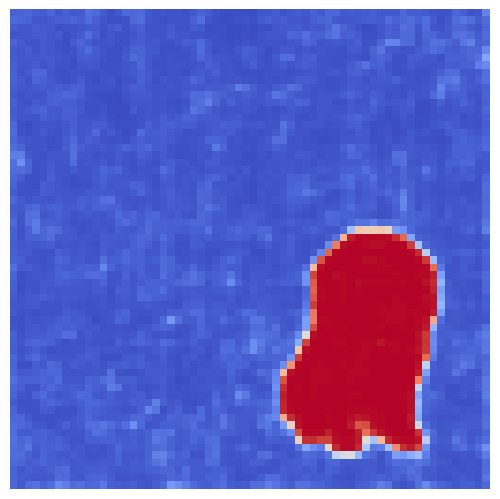

In [ ]:
import matplotlib.pyplot as plt
###
condition_mask, c_masked_image_latents = pipeline.prepare_mask_condition(init_image,mask)
EDITOR=freecond_editor
mask=condition_mask[0][0]
step=25
layer=0 # ❗ the self-attention layer is evenly indexed (0, 2, 4, 6.... 32)
indicator="c"
###
step=25
attn = EDITOR.self_atn_dict[indicator][step][layer][0]
attn_out_1c = vis_self_1c(attn,mask).numpy()

plt.imshow(attn_out_1c , cmap='coolwarm')
#plt.colorbar()  
plt.axis('off')  
plt.tight_layout(pad=0)
plt.savefig("./demo_out/self_attn.png", bbox_inches='tight', pad_inches=0)

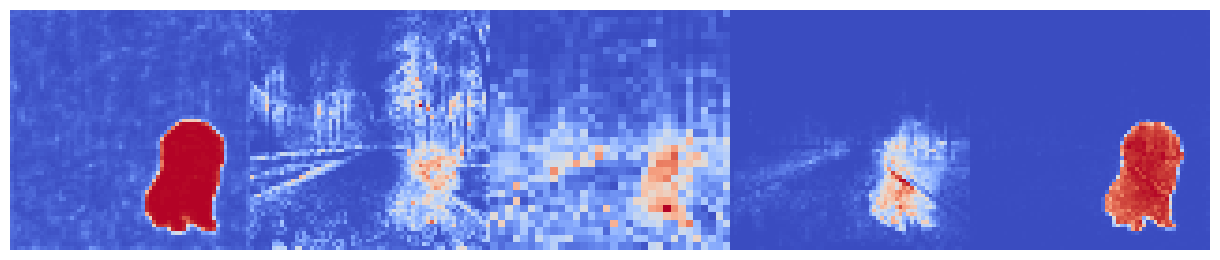

In [17]:
import matplotlib.pyplot as plt
step=25
layers=[0,2,6,28,30] # ❗ the self-attention layer is evenly indexed (0, 2, 4, 6.... 30)
attn = EDITOR.self_atn_dict[indicator][step][layer][0]
attn_out_1c = vis_self_1c(attn,mask).numpy()

plt.figure(figsize=(12, 6))
for i, layer in enumerate(layers):
    plt.subplot(1,len(layers),i+1)
    attn = EDITOR.self_atn_dict[indicator][step][layer][0]
    attn_out_1c = vis_self_1c(attn,mask).numpy()
    plt.imshow(attn_out_1c , cmap='coolwarm')
    #plt.colorbar()  
    plt.axis('off')  
    plt.tight_layout(pad=0)
plt.savefig("./demo_out/self_attn_multi.png", bbox_inches='tight', pad_inches=0)